In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

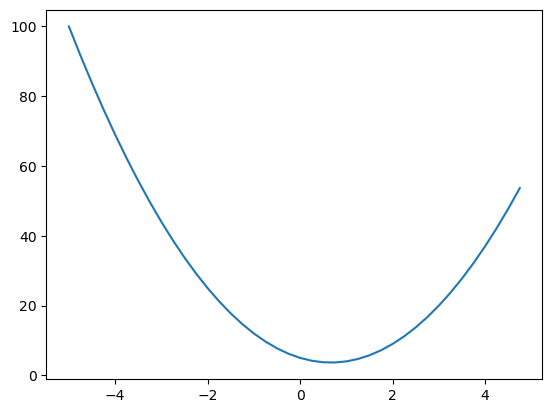

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [219]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op=_op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other

    def __exp__(self, other):
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other ** -1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2 ) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()




In [220]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [221]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'})
    nodes, edges = trace(root)
    print(nodes)
    print(len(nodes))
    print(edges)
    print(len(edges))

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

{Value(data=-6.0), Value(data=-2.0), Value(data=-8.0), Value(data=-3.0), Value(data=2.0), Value(data=4.0), Value(data=10.0)}
7
{(Value(data=-3.0), Value(data=-6.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-2.0), Value(data=-8.0)), (Value(data=4.0), Value(data=-8.0)), (Value(data=-6.0), Value(data=4.0)), (Value(data=10.0), Value(data=4.0))}
6


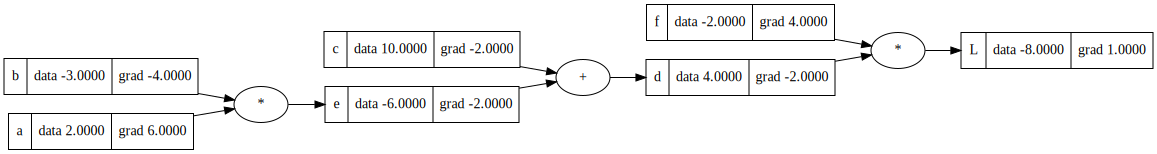

In [222]:
L.backward()
draw_dot((L))

In [226]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

{Value(data=6.881373587019543), Value(data=-3.0), Value(data=0.0), Value(data=0.0), Value(data=2.0), Value(data=-6.0), Value(data=1.0), Value(data=-6.0), Value(data=0.7071067811865476), Value(data=0.8813735870195432)}
10
{(Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=0.0), Value(data=-6.0)), (Value(data=0.0), Value(data=0.0)), (Value(data=0.8813735870195432), Value(data=0.7071067811865476)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=1.0), Value(data=0.0))}
9


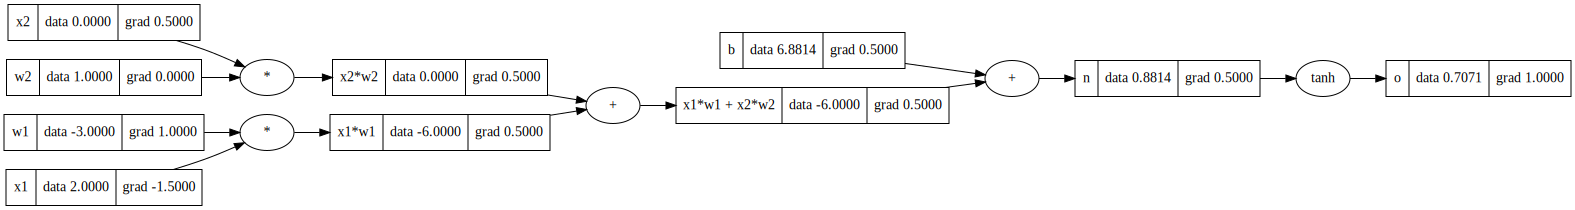

In [227]:
draw_dot(o)


{Value(data=6.828427124746192), Value(data=1.0), Value(data=6.881373587019543), Value(data=4.828427124746192), Value(data=1), Value(data=1.7627471740390863), Value(data=0.7071067811865477), Value(data=0.1464466094067262), Value(data=-6.0), Value(data=-1), Value(data=2), Value(data=5.828427124746192), Value(data=-6.0), Value(data=2.0), Value(data=0.0), Value(data=0.8813735870195432), Value(data=0.0), Value(data=-3.0)}
18
{(Value(data=0.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=4.828427124746192), Value(data=0.7071067811865477)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=6.828427124746192), Value(data=0.1464466094067262)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=1.0), Value(data=0.0)), (Value(data=-1), Value(data=4.828427124746192)), (Value(data=5.828427124746192), Value(data=4.828427124746192)), (Value(data=2), Value(data=1.

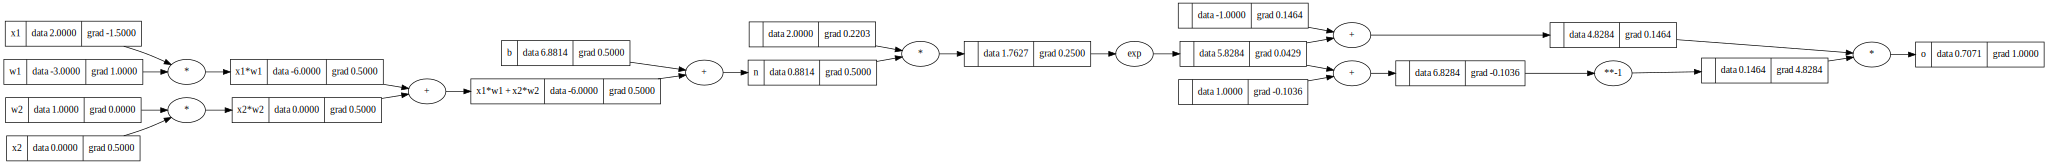

In [228]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [229]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [284]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2,3,-1]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.9500335782218915)

{Value(data=-0.8138930172413676), Value(data=-0.04695466940076298), Value(data=-0.20802470595971267), Value(data=0.9366597670967329), Value(data=-0.45550754449052966), Value(data=-0.13587752135528897), Value(data=0.05200476318925973), Value(data=-0.5554513600118929), Value(data=0.5929682502155893), Value(data=1.7136058924354431), Value(data=1.9183005053118998), Value(data=-0.7556731994594303), Value(data=0.6564266937162544), Value(data=2), Value(data=-0.19147538099975608), Value(data=-0.06210101345577823), Value(data=-0.045287714679752795), Value(data=1.8321253278102987), Value(data=-1), Value(data=2.068811653796544), Value(data=0.2528728594318028), Value(data=0.8964500672468205), Value(data=0.7567699726922227), Value(data=-1), Value(data=-0.39950008695946876), Value(data=-0.8776134144773635), Value(data=-1.305080471973131), Value(data=2.006710640340766), Value(data=2), Value(data=-0.5073170418140054), Value(data=-0.7288457715708783), Value(data=-0.3154554221213075), Value(data=0.27077

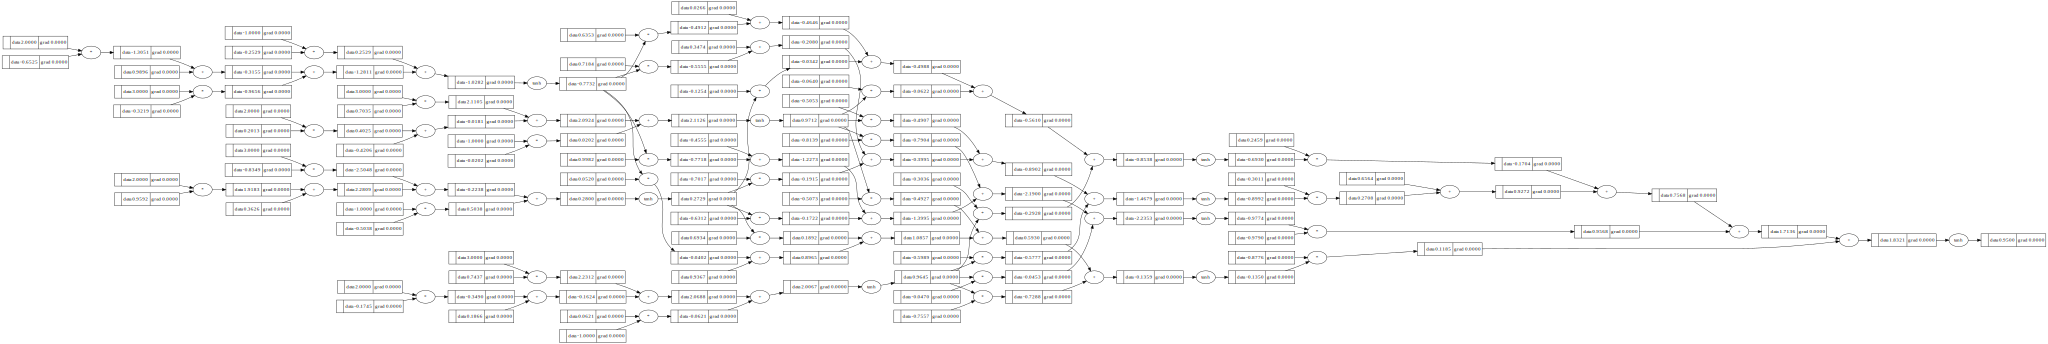

In [285]:
draw_dot(n(x))

In [286]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [287]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 5.6143622580568175
1 2.3582160556499097
2 1.1858734286898254
3 0.4368257552592676
4 0.2416188861647497
5 0.17979079380144325
6 0.14197784388835305
7 0.11662052355651023
8 0.09853552655204895
9 0.08504267394363843
10 0.0746226332184162
11 0.06635317058803954
12 0.059643788325896854
13 0.05409979339154503
14 0.04944786952606901
15 0.045493055347470675
16 0.042092729750881006
17 0.03914027007048494
18 0.036554445315946406
19 0.03427233375021978


In [234]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.046144229966978804),
 Value(data=-0.23911698734048564),
 Value(data=-0.5598527235593725),
 Value(data=-0.08100780085725184)]

In [238]:
loss = sum([(yout - ygt)** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.035668199319356)

In [239]:
loss.backward()

In [243]:
n.layers[0].neurons[0].w[0].grad

-0.05301808490319773

{Value(data=0.14142949024445328), Value(data=-0.6609102603539312), Value(data=0.6262002673038112), Value(data=0.011186844037780252), Value(data=-0.24383734016981978), Value(data=0.691519110082983), Value(data=-0.23911698734048564), Value(data=-0.36396343293514405), Value(data=-0.3717387357867538), Value(data=-0.4411675232205032), Value(data=2.0), Value(data=0.5), Value(data=0.31978037429622913), Value(data=-1.271952121593758), Value(data=-0.3304551301769656), Value(data=0.6168167594987621), Value(data=0.7929656212701162), Value(data=-0.1890256399325123), Value(data=0.05125409222307309), Value(data=1.5770293131952324), Value(data=3.0), Value(data=0.9365971337949912), Value(data=-1.0), Value(data=-0.47898650032364176), Value(data=1.0), Value(data=0.011186844037780252), Value(data=-0.1000944087374485), Value(data=1.562217949428518), Value(data=0.4920127545115433), Value(data=-0.8979465683666348), Value(data=-0.17783879589473206), Value(data=0.783554859299638), Value(data=0.836502725057542

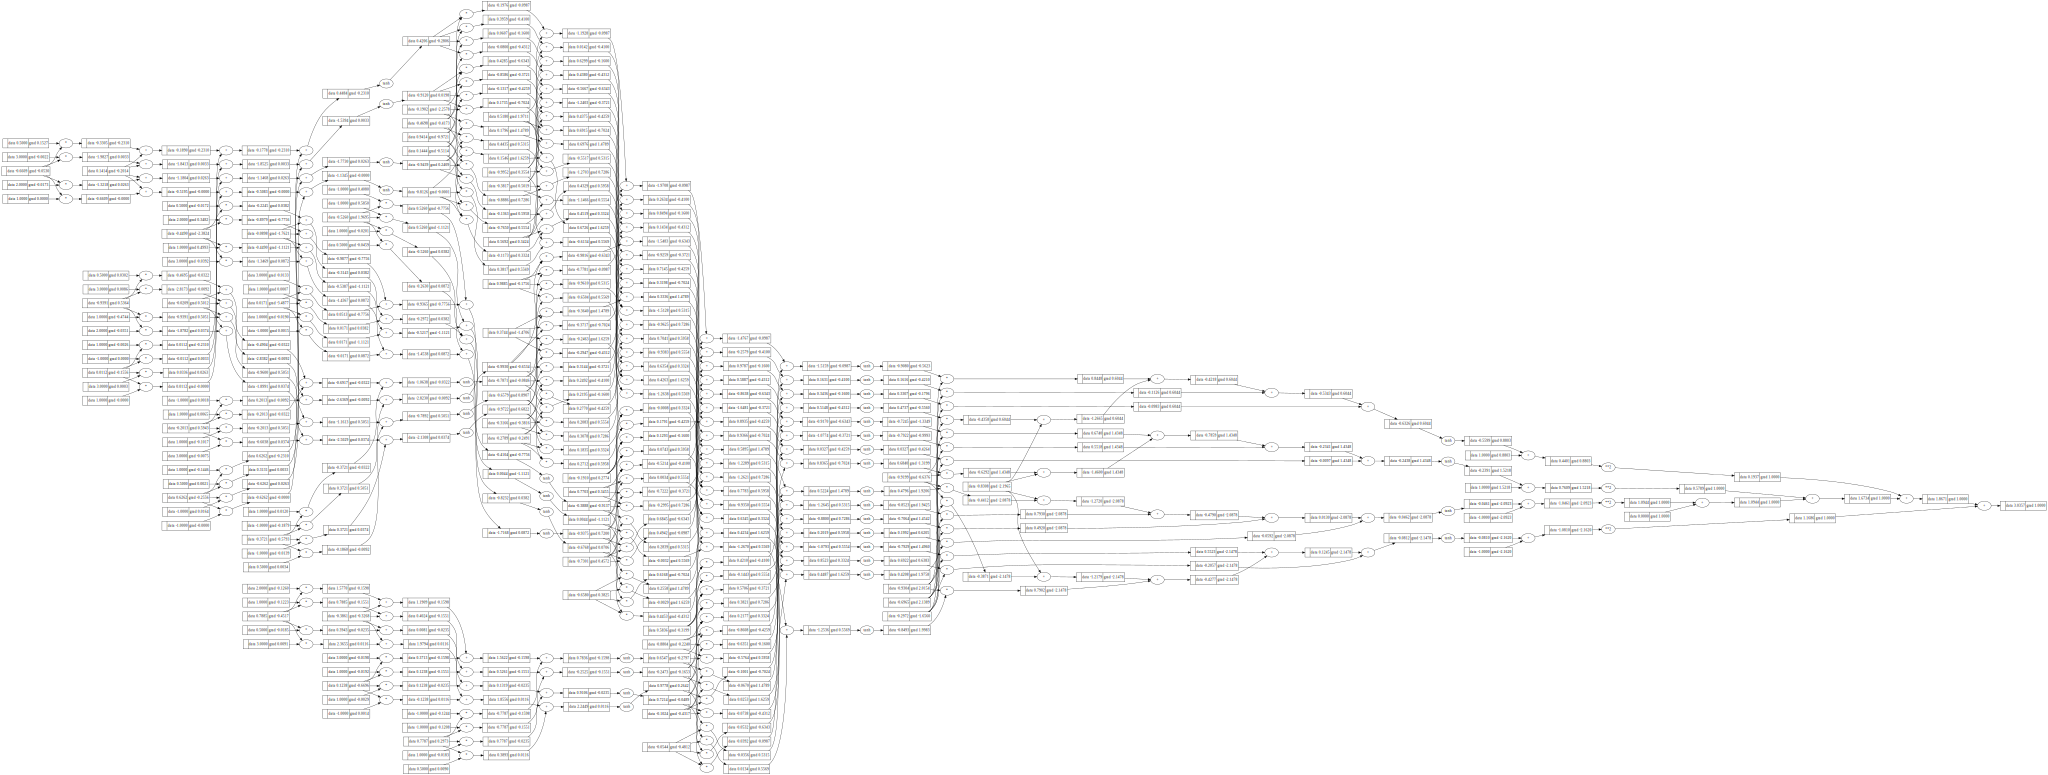

In [244]:
draw_dot(loss)